In [10]:
import os
import time
import math
from typing import List

import torch
import torch.nn as nn
import numpy as np

import pandas as pd
from pandas.tseries import offsets
from pandas.tseries.frequencies import to_offset
from torch.utils.data import Dataset, DataLoader


In [11]:
MODEL = 'micn'
MODE = 'regre'
DATA = 'Trading'
FEATURES = 'S'
FREQ = 'h'
CONV_KERNEL = [12, 16]
D_LAYERS = 1
D_MODEL = 512
SEQ_LEN = 96
DATA_PATH = '5m_intraday_data.csv'
TARGET = 'Close'
ENC_IN = 1
DEC_IN = 1
C_OUT = 1
LABEL_LEN = 96
PRED_LEN = 96
BATCH_SIZE= 32
N_HEADS = 8
DROPOUT = 0.05
EMBED = 'timeF'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DECOMP_KERNEL = [13, 17]
ISOMETRIC_KERNEL = [17, 13]
INVERSE = False
OUTPUT_ATTENTION = False

## Utils

In [12]:

def adjust_learning_rate(optimizer, epoch, args):
    # lr = args.learning_rate * (0.2 ** (epoch // 2))
    if args.lradj=='type1':
        lr_adjust = {epoch: args.learning_rate * (0.75 ** ((epoch-1) // 1))}
    elif args.lradj=='type2':
        lr_adjust = {
            2: 5e-4, 4: 1e-4, 6: 5e-5, 8: 1e-5,
            10: 5e-6, 15: 1e-6, 20: 5e-7
        }
    if epoch in lr_adjust.keys():
        lr = lr_adjust[epoch]
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        print('Updating learning rate to {}'.format(lr))

class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model, path):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, path):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), path+'/'+'checkpoint.pth')
        self.val_loss_min = val_loss

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

class StandardScaler():
    def __init__(self):
        self.mean = 0.
        self.std = 1.

    def fit(self, data):
        self.mean = data.mean(0)
        self.std = data.std(0)

    def transform(self, data):
        mean = torch.from_numpy(self.mean).type_as(data).to(data.device) if torch.is_tensor(data) else self.mean
        std = torch.from_numpy(self.std).type_as(data).to(data.device) if torch.is_tensor(data) else self.std
        return (data - mean) / std

    def inverse_transform(self, data):
        mean = torch.from_numpy(self.mean).type_as(data).to(data.device) if torch.is_tensor(data) else self.mean
        std = torch.from_numpy(self.std).type_as(data).to(data.device) if torch.is_tensor(data) else self.std
        return (data * std) + mean



class TimeFeature:
    def __init__(self):
        pass

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        pass

    def __repr__(self):
        return self.__class__.__name__ + "()"

class SecondOfMinute(TimeFeature):
    """Minute of hour encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.second / 59.0 - 0.5

class MinuteOfHour(TimeFeature):
    """Minute of hour encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.minute / 59.0 - 0.5

class HourOfDay(TimeFeature):
    """Hour of day encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.hour / 23.0 - 0.5

class DayOfWeek(TimeFeature):
    """Hour of day encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.dayofweek / 6.0 - 0.5

class DayOfMonth(TimeFeature):
    """Day of month encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.day - 1) / 30.0 - 0.5

class DayOfYear(TimeFeature):
    """Day of year encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.dayofyear - 1) / 365.0 - 0.5

class MonthOfYear(TimeFeature):
    """Month of year encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.month - 1) / 11.0 - 0.5

class WeekOfYear(TimeFeature):
    """Week of year encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.isocalendar().week - 1) / 52.0 - 0.5

def time_features_from_frequency_str(freq_str: str) -> List[TimeFeature]:
    """
    Returns a list of time features that will be appropriate for the given frequency string.
    Parameters
    ----------
    freq_str
        Frequency string of the form [multiple][granularity] such as "12H", "5min", "1D" etc.
    """

    features_by_offsets = {
        offsets.YearEnd: [],
        offsets.QuarterEnd: [MonthOfYear],
        offsets.MonthEnd: [MonthOfYear],
        offsets.Week: [DayOfMonth, WeekOfYear],
        offsets.Day: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.BusinessDay: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Hour: [HourOfDay, DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Minute: [
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
        offsets.Second: [
            SecondOfMinute,
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
    }

    offset = to_offset(freq_str)

    for offset_type, feature_classes in features_by_offsets.items():
        if isinstance(offset, offset_type):
            return [cls() for cls in feature_classes]

    supported_freq_msg = f"""
    Unsupported frequency {freq_str}
    The following frequencies are supported:
        Y   - yearly
            alias: A
        M   - monthly
        W   - weekly
        D   - daily
        B   - business days
        H   - hourly
        T   - minutely
            alias: min
        S   - secondly
    """
    raise RuntimeError(supported_freq_msg)

def time_features(dates, timeenc=1, freq='h'):
    """
    > `time_features` takes in a `dates` dataframe with a 'dates' column and extracts the date down to `freq` where freq can be any of the following if `timeenc` is 0:
    > * m - [month]
    > * w - [month]
    > * d - [month, day, weekday]
    > * b - [month, day, weekday]
    > * h - [month, day, weekday, hour]
    > * t - [month, day, weekday, hour, *minute]
    >
    > If `timeenc` is 1, a similar, but different list of `freq` values are supported (all encoded between [-0.5 and 0.5]):
    > * Q - [month]
    > * M - [month]
    > * W - [Day of month, week of year]
    > * D - [Day of week, day of month, day of year]
    > * B - [Day of week, day of month, day of year]
    > * H - [Hour of day, day of week, day of month, day of year]
    > * T - [Minute of hour*, hour of day, day of week, day of month, day of year]
    > * S - [Second of minute, minute of hour, hour of day, day of week, day of month, day of year]

    *minute returns a number from 0-3 corresponding to the 15 minute period it falls into.
    """
    if timeenc==0:
        dates['month'] = dates.date.apply(lambda row:row.month,1)
        dates['day'] = dates.date.apply(lambda row:row.day,1)
        dates['weekday'] = dates.date.apply(lambda row:row.weekday(),1)
        dates['hour'] = dates.date.apply(lambda row:row.hour,1)
        dates['minute'] = dates.date.apply(lambda row:row.minute,1)
        dates['minute'] = dates.minute.map(lambda x:x//15)
        print("dates", dates)
        freq_map = {
            'y':[],'m':['month'],'w':['month'],'d':['month','day','weekday'],
            'b':['month','day','weekday'],'h':['month','day','weekday','hour'],
            't':['month','day','weekday','hour','minute'],
        }
        print(dates[freq_map[freq.lower()]].values)
        return dates[freq_map[freq.lower()]].values
    if timeenc==1:
        dates = pd.to_datetime(dates.date.values)
        return np.vstack([feat(dates) for feat in time_features_from_frequency_str(freq)]).transpose(1,0)

In [13]:

class Trading_dataset(Dataset):
    def __init__(self, root_path, flag='train', size=None,
                 features='S', data_path='5m_intraday_data.csv',
                 target='Close', scale=True, inverse=True, timeenc=0, freq='5T', cols=None):
        # size [seq_len, label_len, pred_len]
        if size is None:
            self.seq_len = SEQ_LEN  # Adjust based on your needs
            self.label_len = LABEL_LEN
            self.pred_len = PRED_LEN
        else:
            self.seq_len = size[0]
            self.label_len = size[1]
            self.pred_len = size[2]

        # Initialize dataset type
        assert flag in ['train', 'test', 'val']
        type_map = {'train': 0, 'val': 1, 'test': 2}
        self.set_type = type_map[flag]

        self.features = features
        self.target = target
        self.scale = scale
        self.inverse = inverse
        self.timeenc = timeenc
        self.freq = freq
        self.cols = cols
        self.root_path = root_path
        self.data_path = data_path
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()

        # Load the CSV file
        df_raw = pd.read_csv(os.path.join(self.root_path, self.data_path))

        # Dropping Gmtoffset column
        df_raw = df_raw.drop(columns=['Gmtoffset'])

        # Strip any spaces in column names just in case
        df_raw.columns = df_raw.columns.str.strip()

        # Check if the target column exists
        if self.target not in df_raw.columns:
            raise ValueError(f"Target column '{self.target}' not found in the dataset")

        # Check for NaN values and replace them (customize this based on how you want to handle NaNs)
        if df_raw.isnull().values.any():
            print("NaN values found in the dataset, replacing with forward fill (ffill)")
            df_raw.fillna(method='ffill', inplace=True)  # Replace NaNs with forward fill

        # Select columns (features)
        if self.cols:
            cols = self.cols.copy()
            if self.target in cols:
                cols.remove(self.target)
        else:
            # Use all columns except Timestamp, Datetime, and target
            cols = list(df_raw.columns)
            cols.remove(self.target)  # Ensure the target column is in the list
            cols.remove('Timestamp')  # Unix timestamp
            cols.remove('Datetime')   # Human-readable date

        # Reorder the dataframe to have Datetime, features, and target
        df_raw = df_raw[['Datetime'] + cols + [self.target]]

        # Train/Val/Test splits
        num_train = int(len(df_raw) * 0.7)
        num_test = int(len(df_raw) * 0.2)
        num_vali = len(df_raw) - num_train - num_test
        border1s = [0, num_train - self.seq_len, len(df_raw) - num_test - self.seq_len]
        border2s = [num_train, num_train + num_vali, len(df_raw)]
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]

        # Features and target data selection
        if self.features == 'M' or self.features == 'MS':
            # Multivariate: use all columns except target and Datetime
            cols_data = df_raw.columns[1:]
            df_data = df_raw[cols_data]
        elif self.features == 'S':
            # Single feature: only use the target column
            df_data = df_raw[[self.target]]

        # Scaling the data if required
        if self.scale:
            train_data = df_data[border1s[0]:border2s[0]]  # Only scale using the training data
            train_data = np.nan_to_num(train_data)  # Replace NaNs and infinities with 0
            self.scaler.fit(train_data)
            data = self.scaler.transform(np.nan_to_num(df_data.values))  # Apply scaling to the entire data
        else:
            data = df_data.values

        # Processing the datetime column for timestamp encoding
        df_stamp = df_raw[['Datetime']][border1:border2]
        df_stamp = df_stamp.rename(columns={'Datetime': 'date'})  # Rename 'Datetime' to 'date' for compatibility
        df_stamp['date'] = pd.to_datetime(df_stamp['date'])
        data_stamp = time_features(df_stamp, timeenc=self.timeenc, freq=self.freq)

        # Save the data for X (features) and y (target)
        self.data_x = data[border1:border2]
        if self.inverse:
            self.data_y = df_data.values[border1:border2]  # Original scale for y if inverse
        else:
            self.data_y = data[border1:border2]  # Scaled version

        # Store time-related features
        self.data_stamp = data_stamp

    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len

        # Ensure valid sequence boundaries to avoid out-of-bounds indexing
        if s_end > len(self.data_x) or r_end > len(self.data_x):
            raise IndexError(f"Index out of bounds: s_end={s_end}, r_end={r_end}")

        # Getting sequences for X (input) and Y (target)
        seq_x = self.data_x[s_begin:s_end]
        if self.inverse:
            seq_y = np.concatenate([self.data_x[r_begin:r_begin+self.label_len], self.data_y[r_begin+self.label_len:r_end]], 0)
        else:
            seq_y = self.data_x[r_begin:r_end]

        # Getting sequences for time encoding
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]

        # Debugging print to check for NaN values in the sequences
        if np.isnan(seq_x).any() or np.isnan(seq_y).any():
            print(f"NaN values detected at index {index}")

        return seq_x, seq_y, seq_x_mark, seq_y_mark

    def __len__(self):
        return len(self.data_x) - self.seq_len - self.pred_len + 1

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)


In [14]:
train_loader = DataLoader(
    Trading_dataset(flag='train', root_path=r"data/ETT/", data_path="5m_intraday_data.csv", freq=FREQ),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    drop_last=True)

vali_loader = DataLoader(
    Trading_dataset(flag='val', root_path=r"data/ETT/", data_path="5m_intraday_data.csv", freq=FREQ),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    drop_last=True)

test_loader = DataLoader(
    Trading_dataset(flag='test', root_path=r"data/ETT/", data_path="5m_intraday_data.csv", freq=FREQ),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    drop_last=False)

NaN values found in the dataset, replacing with forward fill (ffill)
dates                      date  month  day  weekday  hour  minute
0     2023-02-09 14:30:00      2    9        3    14       2
1     2023-02-09 14:35:00      2    9        3    14       2
2     2023-02-09 14:40:00      2    9        3    14       2
3     2023-02-09 14:45:00      2    9        3    14       3
4     2023-02-09 14:50:00      2    9        3    14       3
...                   ...    ...  ...      ...   ...     ...
22703 2024-04-04 15:20:00      4    4        3    15       1
22704 2024-04-04 15:25:00      4    4        3    15       1
22705 2024-04-04 15:30:00      4    4        3    15       2
22706 2024-04-04 15:35:00      4    4        3    15       2
22707 2024-04-04 15:40:00      4    4        3    15       2

[22708 rows x 6 columns]
[[ 2  9  3 14]
 [ 2  9  3 14]
 [ 2  9  3 14]
 ...
 [ 4  4  3 15]
 [ 4  4  3 15]
 [ 4  4  3 15]]
NaN values found in the dataset, replacing with forward fill (ffill)
da

C:\Users\UseR\AppData\Local\Temp\ipykernel_3004\1111285665.py:50: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_raw.fillna(method='ffill', inplace=True)  # Replace NaNs with forward fill
C:\Users\UseR\AppData\Local\Temp\ipykernel_3004\9620485.py:203: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  dates['month'] = dates.date.apply(lambda row:row.month,1)
C:\Users\UseR\AppData\Local\Temp\ipykernel_3004\9620485.py:204: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  dates['day'] = dates.date.apply(lambda row:row.day,1)
C:\Users\UseR\AppData\Local\Temp\ipykernel_3004\9620485.py:205: FutureWarning: the convert_dtype parameter is deprecat

In [15]:
class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEmbedding, self).__init__()
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.size(1)]

class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        padding = 1 if torch.__version__>='1.5.0' else 2
        self.tokenConv = nn.Conv1d(in_channels=c_in, out_channels=d_model,
                                    kernel_size=3, padding=padding, padding_mode='circular')
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight,mode='fan_in',nonlinearity='leaky_relu')

    def forward(self, x):
        x = self.tokenConv(x.permute(0, 2, 1)).transpose(1,2)
        return x

class FixedEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(FixedEmbedding, self).__init__()

        w = torch.zeros(c_in, d_model).float()
        w.require_grad = False

        position = torch.arange(0, c_in).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()

        w[:, 0::2] = torch.sin(position * div_term)
        w[:, 1::2] = torch.cos(position * div_term)

        self.emb = nn.Embedding(c_in, d_model)
        self.emb.weight = nn.Parameter(w, requires_grad=False)

    def forward(self, x):
        return self.emb(x).detach()

class TemporalEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='fixed', freq='h'):
        super(TemporalEmbedding, self).__init__()

        minute_size = 4; hour_size = 24
        weekday_size = 7; day_size = 32; month_size = 13

        Embed = FixedEmbedding if embed_type=='fixed' else nn.Embedding
        if freq=='t':
            self.minute_embed = Embed(minute_size, d_model)
        self.hour_embed = Embed(hour_size, d_model)
        self.weekday_embed = Embed(weekday_size, d_model)
        self.day_embed = Embed(day_size, d_model)
        self.month_embed = Embed(month_size, d_model)

    def forward(self, x):
        x = x.long()

        minute_x = self.minute_embed(x[:,:,4]) if hasattr(self, 'minute_embed') else 0.
        hour_x = self.hour_embed(x[:,:,3])
        weekday_x = self.weekday_embed(x[:,:,2])
        day_x = self.day_embed(x[:,:,1])
        month_x = self.month_embed(x[:,:,0])

        return hour_x + weekday_x + day_x + month_x + minute_x

class TimeFeatureEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='timeF', freq='h'):
        super(TimeFeatureEmbedding, self).__init__()

        freq_map = {'h':4, 't':5, 's':6, 'm':1, 'a':1, 'w':2, 'd':3, 'b':3}
        d_inp = freq_map[freq]
        self.embed = nn.Linear(d_inp, d_model)

    def forward(self, x):
        return self.embed(x)

class DataEmbedding(nn.Module):
    def __init__(self, c_in, d_model, embed_type='fixed', freq='h', dropout=0.1):
        super(DataEmbedding, self).__init__()

        self.value_embedding = TokenEmbedding(c_in=c_in, d_model=d_model)
        self.position_embedding = PositionalEmbedding(d_model=d_model)
        self.temporal_embedding = TemporalEmbedding(d_model=d_model, embed_type=embed_type, freq=freq) if embed_type!='timeF' else TimeFeatureEmbedding(d_model=d_model, embed_type=embed_type, freq=freq)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_mark):

        x = self.value_embedding(x) + self.position_embedding(x) + self.temporal_embedding(x_mark)
        return self.dropout(x)

In [16]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """

    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # x shape: batch,seq_len,channels
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x


class series_decomp(nn.Module):
    """
    Series decomposition block
    """

    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean


class series_decomp_multi(nn.Module):
    """
    Series decomposition block
    """

    def __init__(self, kernel_size):
        super(series_decomp_multi, self).__init__()
        self.kernel_size = kernel_size
        self.moving_avg = [moving_avg(kernel, stride=1) for kernel in kernel_size]

    def forward(self, x):
        moving_mean = []
        res = []
        for func in self.moving_avg:
            moving_avg = func(x)
            moving_mean.append(moving_avg)
            sea = x - moving_avg
            res.append(sea)

        sea = sum(res) / len(res)
        moving_mean = sum(moving_mean) / len(moving_mean)
        return sea, moving_mean


class FeedForwardNetwork(nn.Module):
    def __init__(self, hidden_size, filter_size, dropout_rate=0.1):
        super(FeedForwardNetwork, self).__init__()

        self.layer1 = nn.Linear(hidden_size, filter_size)
        self.relu = nn.ReLU()

        self.dropout = nn.Dropout(dropout_rate)
        self.layer2 = nn.Linear(filter_size, hidden_size)

        self.initialize_weight(self.layer1)
        self.initialize_weight(self.layer2)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer2(x)
        return x

    def initialize_weight(self, x):
        nn.init.xavier_uniform_(x.weight)
        if x.bias is not None:
            nn.init.constant_(x.bias, 0)


class MIC(nn.Module):
    """
    MIC layer to extract local and global features
    """
    def __init__(self, feature_size=512, n_heads=8, dropout=0.05, decomp_kernel=[32], conv_kernel=[24], isometric_kernel=[18, 6], device='cuda'):
        super(MIC, self).__init__()
        self.src_mask = None
        self.conv_kernel = conv_kernel
        self.isometric_kernel = isometric_kernel
        self.device = device

        # isometric convolution
        self.isometric_conv = nn.ModuleList([nn.Conv1d(in_channels=feature_size, out_channels=feature_size,
                                                   kernel_size=i,padding=0,stride=1)
                                        for i in isometric_kernel])

        # downsampling convolution: padding=i//2, stride=i
        self.conv = nn.ModuleList([nn.Conv1d(in_channels=feature_size, out_channels=feature_size,
                                             kernel_size=i,padding=i//2,stride=i)
                                  for i in conv_kernel])

        # upsampling convolution
        self.conv_trans = nn.ModuleList([nn.ConvTranspose1d(in_channels=feature_size, out_channels=feature_size,
                                                            kernel_size=i,padding=0,stride=i)
                                        for i in conv_kernel])

        self.decomp = nn.ModuleList([series_decomp(k) for k in decomp_kernel])
        self.merge = torch.nn.Conv2d(in_channels=feature_size, out_channels=feature_size, kernel_size=(len(self.conv_kernel), 1))

        self.fnn = FeedForwardNetwork(feature_size, feature_size*4, dropout)
        self.fnn_norm = torch.nn.LayerNorm(feature_size)

        self.norm = torch.nn.LayerNorm(feature_size)
        self.act = torch.nn.Tanh()
        self.drop = torch.nn.Dropout(0.05)

    def conv_trans_conv(self, input, conv1d, conv1d_trans, isometric):
        batch, seq_len, channel = input.shape
        x = input.permute(0, 2, 1)

        # downsampling convolution
        x1 = self.drop(self.act(conv1d(x)))
        x = x1

        # print(f"debug: {x.shape} | {x1.shape}")

        # isometric convolution
        zeros = torch.zeros((x.shape[0], x.shape[1], x.shape[2]-1), device=self.device)
        x = torch.cat((zeros, x), dim=-1)
        x = self.drop(self.act(isometric(x)))
        x = self.norm((x+x1).permute(0, 2, 1)).permute(0, 2, 1)

        # upsampling convolution
        x = self.drop(self.act(conv1d_trans(x)))
        x = x[:, :, :seq_len]   # truncate

        x = self.norm(x.permute(0, 2, 1) + input)
        return x


    def forward(self, src):
        # multi-scale
        multi = []
        for i in range(len(self.conv_kernel)):
            src_out, trend1 = self.decomp[i](src)
            src_out = self.conv_trans_conv(src_out, self.conv[i], self.conv_trans[i], self.isometric_conv[i])
            multi.append(src_out)

        # merge
        mg = torch.tensor([], device = self.device)
        for i in range(len(self.conv_kernel)):
            mg = torch.cat((mg, multi[i].unsqueeze(1)), dim=1)
        mg = self.merge(mg.permute(0,3,1,2)).squeeze(-2).permute(0,2,1)

        return self.fnn_norm(mg + self.fnn(mg))


class Seasonal_Prediction(nn.Module):
    def __init__(self, embedding_size=512, n_heads=8, dropout=0.05, d_layers=1, decomp_kernel=[32], c_out=1,
                conv_kernel=[2, 4], isometric_kernel=[18, 6], device='cuda'):
        super(Seasonal_Prediction, self).__init__()

        self.mic = nn.ModuleList([MIC(feature_size=embedding_size, n_heads=n_heads,
                                                   decomp_kernel=decomp_kernel,conv_kernel=conv_kernel, isometric_kernel=isometric_kernel, device=device)
                                      for i in range(d_layers)])

        self.projection = nn.Linear(embedding_size, c_out)

    def forward(self, dec):
        for mic_layer in self.mic:
            dec = mic_layer(dec)
        return self.projection(dec)



In [17]:
class MICN(nn.Module):
    def __init__(self, dec_in, c_out, seq_len, label_len, out_len,
                 d_model=512, n_heads=8,d_layers=2,
                 dropout=0.0,embed='fixed', freq='h',
                 device=torch.device('cuda:0'), mode='regre',
                 decomp_kernel=[33], conv_kernel=[12, 24], isometric_kernel=[18, 6],):
        super(MICN, self).__init__()

        self.pred_len = out_len
        self.seq_len = seq_len
        self.c_out = c_out
        self.decomp_kernel = decomp_kernel
        self.mode = mode

        self.decomp_multi = series_decomp_multi(decomp_kernel)

        # embedding
        self.dec_embedding = DataEmbedding(dec_in, d_model, embed, freq, dropout)

        self.conv_trans = Seasonal_Prediction(embedding_size=d_model, n_heads=n_heads, dropout=dropout,
                                     d_layers=d_layers, decomp_kernel=decomp_kernel, c_out=c_out, conv_kernel=conv_kernel,
                                     isometric_kernel=isometric_kernel, device=device)

        self.regression = nn.Linear(seq_len, out_len)
        self.regression.weight = nn.Parameter((1/out_len) * torch.ones([out_len, seq_len]), requires_grad=True)

    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec,
                enc_self_mask=None, dec_self_mask=None, dec_enc_mask=None):

        # trend-cyclical prediction block: regre or mean
        if self.mode == 'regre':
            seasonal_init_enc, trend = self.decomp_multi(x_enc)
            trend = self.regression(trend.permute(0,2,1)).permute(0, 2, 1)
        elif self.mode == 'mean':
            mean = torch.mean(x_enc, dim=1).unsqueeze(1).repeat(1, self.pred_len, 1)
            seasonal_init_enc, trend = self.decomp_multi(x_enc)
            trend = torch.cat([trend[:, -self.seq_len:, :], mean], dim=1)

        # embedding
        zeros = torch.zeros([x_dec.shape[0], self.pred_len, x_dec.shape[2]], device=x_enc.device)
        seasonal_init_dec = torch.cat([seasonal_init_enc[:, -self.seq_len:, :], zeros], dim=1)
        dec_out = self.dec_embedding(seasonal_init_dec, x_mark_dec)

        dec_out = self.conv_trans(dec_out)
        dec_out = dec_out[:, -self.pred_len:, :] + trend[:, -self.pred_len:, :]
        return dec_out

In [18]:

def build_model():
    model_dict = {
        'micn': MICN,
    }
    model = model_dict[MODEL](
        DEC_IN,
        C_OUT,
        SEQ_LEN,
        LABEL_LEN,
        PRED_LEN,
        D_MODEL,
        N_HEADS,
        D_LAYERS,
        DROPOUT,
        EMBED,
        FREQ,
        DEVICE,
        MODE,
        DECOMP_KERNEL,
        CONV_KERNEL,
        ISOMETRIC_KERNEL
    ).float()
    return model

# Optimizer and loss function
def select_optimizer(model):
    return torch.optim.Adam(model.parameters(), lr=0.001)

def select_criterion():
    return nn.MSELoss()

# Validation function
def validate(model, vali_loader, criterion):
    model.eval()
    total_loss = []
    with torch.no_grad():
        for batch_x, batch_y, batch_x_mark, batch_y_mark in vali_loader:
            pred, true = process_one_batch(model, batch_x, batch_y, batch_x_mark, batch_y_mark)
            loss = criterion(pred, true)
            total_loss.append(loss.item())
    return np.average(total_loss)

# Training function
def train(model, train_loader, vali_loader, epochs=100):
    optimizer = select_optimizer(model)
    criterion = select_criterion()
    early_stopping = EarlyStopping(patience=5, verbose=True)

    print('===== Started Model training =====')

    for epoch in range(epochs):
        model.train()
        train_loss = []
        iter_count = 0
        time_now = time.time()

        for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(train_loader):
            optimizer.zero_grad()
            pred, true = process_one_batch(model, batch_x, batch_y, batch_x_mark, batch_y_mark)
            loss = criterion(pred, true)
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            iter_count += 1
            if (i + 1) % 10 == 0:
                print(f"\titers: {i + 1}, epoch: {epoch + 1} | loss: {loss.item():.7f}")
                speed = (time.time() - time_now) / iter_count
                left_time = speed * ((epochs - epoch - 1) * len(train_loader) - i)
                print(f'\tspeed: {speed:.4f}s/iter; left time: {left_time:.4f}s')
                iter_count = 0
                time_now = time.time()

        avg_train_loss = np.average(train_loss)
        vali_loss = validate(model, vali_loader, criterion)
        print(f'Epoch: {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {vali_loss:.4f}')

        early_stopping(vali_loss, model, "checkpoints")
        if early_stopping.early_stop:
            print("Early stopping")
            break

def process_one_batch(model, batch_x, batch_y, batch_x_mark, batch_y_mark):
    batch_x = batch_x.float()
    batch_y = batch_y.float()
    batch_x_mark = batch_x_mark.float()
    batch_y_mark = batch_y_mark.float()

    # Prepare decoder input
    # Ensure dec_inp has the correct size for the model
    dec_inp = torch.zeros([batch_y.shape[0], PRED_LEN, batch_y.shape[-1]]).float()  # Adjust padding if needed
    dec_inp = torch.cat([batch_y[:, :LABEL_LEN, :], dec_inp], dim=1)


    # Get model outputs
    outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
    return outputs, batch_y[:, -PRED_LEN:, :]  # Returnin



# Build model
model = build_model()

# Train model
train(model, train_loader, vali_loader, epochs=10)  # Adjust epochs as needed


===== Started Model training =====
	iters: 10, epoch: 1 | loss: 25884.5234375
	speed: 0.3988s/iter; left time: 2519.3501s
	iters: 20, epoch: 1 | loss: 25213.3378906
	speed: 0.3933s/iter; left time: 2480.8384s
	iters: 30, epoch: 1 | loss: 22994.3750000
	speed: 0.4083s/iter; left time: 2571.2504s
	iters: 40, epoch: 1 | loss: 20600.7402344
	speed: 0.4163s/iter; left time: 2617.8771s
	iters: 50, epoch: 1 | loss: 19152.1386719
	speed: 0.4191s/iter; left time: 2630.9282s
	iters: 60, epoch: 1 | loss: 17329.9785156
	speed: 0.4408s/iter; left time: 2762.9150s
	iters: 70, epoch: 1 | loss: 15109.6289062
	speed: 0.4162s/iter; left time: 2604.7658s
	iters: 80, epoch: 1 | loss: 12566.2451172
	speed: 0.4106s/iter; left time: 2565.4349s
	iters: 90, epoch: 1 | loss: 12563.6494141
	speed: 0.4111s/iter; left time: 2564.4409s
	iters: 100, epoch: 1 | loss: 10137.5126953
	speed: 0.4123s/iter; left time: 2567.9374s
	iters: 110, epoch: 1 | loss: 8859.2949219
	speed: 0.4161s/iter; left time: 2587.4450s
	iters:

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def vali(model, d_loader, criterion):
    preds, true_vals = [], []
    with torch.no_grad():
        for batch_x, batch_y, batch_x_mark, batch_y_mark in d_loader:
            batch_x = batch_x.float().to(DEVICE)
            batch_y = batch_y[:, -PRED_LEN:, :].float().to(DEVICE)
            batch_x_mark = batch_x_mark.float().to(DEVICE)
            batch_y_mark = batch_y_mark.float().to(DEVICE)


            dec_inp = torch.zeros([batch_y.shape[0], PRED_LEN, batch_y.shape[-1]], device=DEVICE).float()
            dec_inp = torch.cat([batch_y[:, :LABEL_LEN, :], dec_inp], dim=1)

            outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
            outputs = outputs[:, -PRED_LEN:, :]

            preds.append(outputs.detach().cpu().numpy())
            true_vals.append(batch_y.detach().cpu().numpy())

    preds = np.concatenate(preds, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    if preds.ndim > 2:
        preds = preds.reshape(-1, preds.shape[-1])
    if true_vals.ndim > 2:
        true_vals = true_vals.reshape(-1, true_vals.shape[-1])

    mse = mean_squared_error(true_vals, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true_vals, preds)
    mape = np.mean(np.abs((true_vals - preds) / true_vals)) * 100
    r2 = r2_score(true_vals, preds)

    naive_forecast = np.mean(np.abs(true_vals[:-1] - true_vals[1:]))
    mase = mae / naive_forecast if naive_forecast != 0 else np.nan


    smape = 100 * np.mean(2 * np.abs(preds - true_vals) / (np.abs(true_vals) + np.abs(preds) + 1e-10))

    return {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'r2': r2,
        'mase': mase,
        'smape': smape
    }

vali_metrics = vali(model, vali_loader, select_criterion())
test_metrics = vali(model, test_loader, select_criterion())


print(f"Validation Metrics: MSE: {vali_metrics['mse']:.7f}, RMSE: {vali_metrics['rmse']:.7f}, MAE: {vali_metrics['mae']:.7f}, "
      f"MAPE: {vali_metrics['mape']:.7f}, R²: {vali_metrics['r2']:.7f}, MASE: {vali_metrics['mase']:.7f}, SMAPE: {vali_metrics['smape']:.7f}")

print(f"Test Metrics: MSE: {test_metrics['mse']:.7f}, RMSE: {test_metrics['rmse']:.7f}, MAE: {test_metrics['mae']:.7f}, "
      f"MAPE: {test_metrics['mape']:.7f}, R²: {test_metrics['r2']:.7f}, MASE: {test_metrics['mase']:.7f}, SMAPE: {test_metrics['smape']:.7f}")


Validation Metrics: MSE: 5.9295068, RMSE: 2.4350579, MAE: 1.5298474, MAPE: 0.8561473, R²: 0.9352938, MASE: 5.7369561, SMAPE: 0.8601221
Test Metrics: MSE: 11.7598267, RMSE: 3.4292603, MAE: 2.4420907, MAPE: 1.1104506, R²: 0.8584346, MASE: 8.4439907, SMAPE: 1.1163028


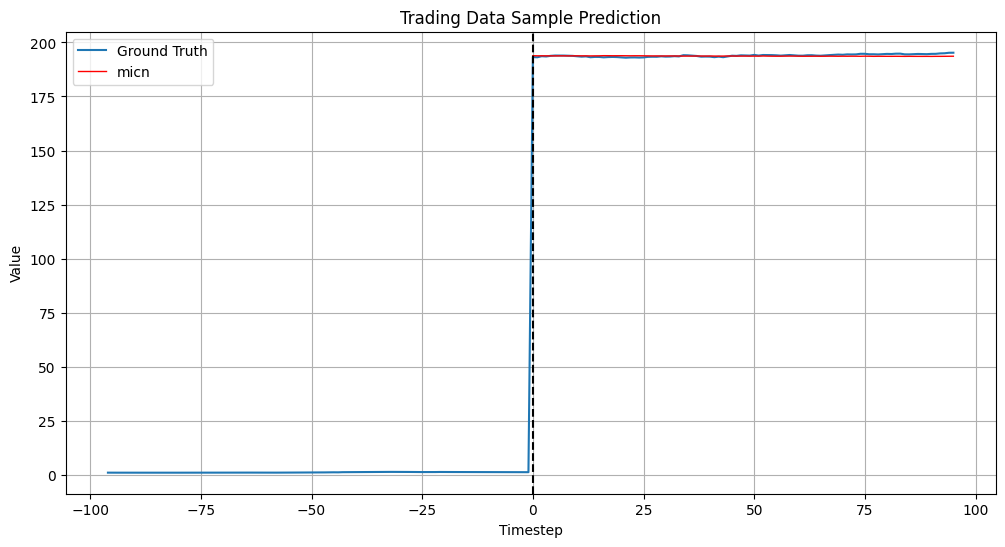

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import torch

X_batch, y_batch, X_mark, y_mark = next(iter(test_loader))

with torch.no_grad():
    dec_inp = torch.zeros([y_batch.shape[0], PRED_LEN, y_batch.shape[-1]], device=DEVICE).float()
    dec_inp = torch.cat([y_batch[:, :LABEL_LEN, :].to(DEVICE), dec_inp], dim=1)

    lin_preds = model(X_batch.float().to(DEVICE), X_mark.float().to(DEVICE), dec_inp, y_mark.float().to(DEVICE)).detach().cpu().numpy()
    lt_preds = lin_preds  

gt = np.concatenate((X_batch[10, -96:, 0].cpu().numpy(), y_batch[10, -PRED_LEN:, 0].cpu().numpy()), axis=0)


plt.figure(figsize=(12, 6))
plt.plot(list(range(-96, PRED_LEN)), gt, label='Ground Truth', linewidth=1.5)
plt.plot(list(range(PRED_LEN)), lin_preds[10, :, 0], label='micn', color='red', linewidth=1)
plt.axvline(x=0, color="k", linestyle='--')  
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.title('Trading Data Sample Prediction')
plt.legend()
plt.grid() 
plt.show()
